### Group 152 Proposal
# Advertisement Detection Using KNN Classification
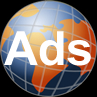

## Introduction
- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question

The dataset was obtained from https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements
* Credits to Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

The dataset is downloaded in a comma separated format. It contains 3 continuous variables (height, width, and ratio), as well as 1554 binary values (0 means no, 1 means yes) regarding the aspects of the image, which was then summed up into one new column called the "Attributes". The Attributes column includes 19 caption features, 111 alt features, 495 base URL features, 472 destination URL features, and 457 in-image URL features. Several missing values are interpreted as a question mark ("?").

## Preliminary exploratory data analysis:
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

## Methods:
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

## Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

**Start by importing the necessary libraries for our modelling**

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Our dataset contains too many rows and columns that will take a long time to read. Hence, we are only taking the first 1000 rows of the dataset and display the necessary columns.

In [13]:
# Read csv data without column name into R 
import_ad_data <- read_csv("Data/ad.data.csv", col_names = FALSE, col_select = c("X1", "X2", "X3", "X1560", "X1559"), n_max = 1000)

# Rename column names and filter out missing values
ad_data <- rename(import_ad_data, Height = X1, Width = X2, Ratio = X3, Attributes = X1560, Type = X1559) |>
           filter(Height != "?" , Width != "?" , Ratio != "?")

glimpse(ad_data)

Rows: 1000 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): X1, X2, X3, X1559
dbl (1): X1560

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 756
Columns: 5
$ Height     <chr> "125", "57", "33", "60", "60", "60", "59", "60", "60", "60"…
$ Width      <chr> "125", "468", "230", "468", "468", "468", "460", "234", "46…
$ Ratio      <chr> "1", "8.2105", "6.9696", "7.8", "7.8", "7.8", "7.7966", "3.…
$ Attributes <dbl> 14, 11, 22, 26, 24, 24, 27, 31, 23, 24, 34, 33, 30, 22, 28,…
$ Type       <chr> "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad.", "ad…


Here we can see how many rows are classified as each type

In [14]:
total_type <- ad_data |>
              group_by(Type) |>
              summarize(n = n())
total_type

Type,n
<chr>,<int>
ad.,386
nonad.,370


The tibble above shows a good split between Ad and Nonad types as they are similar in proportion.

We will set the two distinct image Type as a factor, and convert the columns from character to numeric.

In [17]:
ad_factored <- ad_data |>
               mutate(Height = as.numeric(Height),
                      Width = as.numeric(Width),
                      Ratio = as.numeric(Ratio),
                      Type = as_factor(Type))
ad_factored

Height,Width,Ratio,Attributes,Type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
125,125,1.0000,14,ad.
57,468,8.2105,11,ad.
33,230,6.9696,22,ad.
60,468,7.8000,26,ad.
60,468,7.8000,24,ad.
60,468,7.8000,24,ad.
59,460,7.7966,27,ad.
60,234,3.9000,31,ad.
60,468,7.8000,23,ad.


In [18]:
set.seed(1)

ad_data_recipe <- recipe(Type ~ Height + Width + Ratio + Attributes, data = ad_factored) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors()) |> 
                  prep()

ad_data_standardized <- bake(ad_data_recipe, ad_factored)

ad_split <- initial_split(ad_factored, prop = 0.87, strata = Type)
ad_train <- training(ad_split)
ad_test <- testing(ad_split) 
glimpse(ad_train)
glimpse(ad_test)

data_proportions_train <- ad_train |>
                    group_by(Type) |>
                    summarize(n = n()) |>
                    mutate(percent = 100*n/nrow(ad_train))
data_proportions_train

data_proportions_test <- ad_test |>
                         group_by(Type) |>
                         summarize(n = n()) |>
                         mutate(percent = 100*n/nrow(ad_test))
data_proportions_test

Rows: 656
Columns: 5
$ Height     <dbl> 125, 57, 33, 60, 60, 60, 90, 90, 90, 33, 60, 60, 125, 60, 3…
$ Width      <dbl> 125, 468, 230, 468, 468, 468, 52, 60, 60, 230, 468, 468, 12…
$ Ratio      <dbl> 1.0000, 8.2105, 6.9696, 7.8000, 7.8000, 7.8000, 0.5777, 0.6…
$ Attributes <dbl> 14, 11, 22, 26, 24, 23, 34, 33, 30, 22, 28, 48, 27, 27, 10,…
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…
Rows: 100
Columns: 5
$ Height     <dbl> 60, 59, 60, 60, 90, 60, 60, 125, 125, 60, 60, 60, 60, 100, …
$ Width      <dbl> 468, 460, 234, 468, 60, 468, 468, 125, 125, 468, 234, 468, …
$ Ratio      <dbl> 7.8000, 7.7966, 3.9000, 7.8000, 0.6666, 7.8000, 7.8000, 1.0…
$ Attributes <dbl> 24, 27, 31, 24, 31, 46, 69, 58, 53, 44, 31, 25, 36, 9, 4, 6…
$ Type       <fct> ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad., ad.,…


Type,n,percent
<fct>,<int>,<dbl>
ad.,335,51.06707
nonad.,321,48.93293


Type,n,percent
<fct>,<int>,<dbl>
ad.,51,51
nonad.,49,49


In [ ]:
# Plot to see the relationship between ratio and attributes to type

options(repr.plot.width = 9, repr.plot.height = 7)
ad_plot <- ad_data_standardized |>
           ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
           geom_point()  + 
           xlab("Ratio Standardized") + 
           ylab("Attributes Standardized") +
           labs(colour = "What type of image is this?") +
           theme(text = element_text(size=20)) 
    
ad_plot

options(repr.plot.width = 9, repr.plot.height = 7)
ad_plot2 <- ad_data |>
           ggplot(aes(x = Ratio, y = Attributes, color = Type)) + 
           geom_point()  + 
           xlab("Ratio") + 
           ylab("Attributes") +
           labs(colour = "What type of image is this?") +
           theme(text = element_text(size=20)) 
    
ad_plot2

In [ ]:
# Do the training here with ad_train
